# Simulate Online Learning with Contextual Bandits

For "online learning" to take place, the agent's policy needs to be updated, where "updated" is conceptually similar to retraining a traditional supervised learning model (with latest training examples) and deploying the newly trained model
* the bandit agent's policy is updated (i.e., learns) when it receives (e.g., `agent.train(...)`) a trajectory that includes the prediction/action AND the delayed feedback
* once `agent.train(...)` takes place, the policy is updated (e.g., weights)

In [1]:
!pwd

/home/jupyter/tf_vertex_agents/05-online-learning


In [2]:
# PREFIX = 'mabv1'
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


## Load notebook config

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"
DATA_PATH_KFP_DEMO       = "gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NA

## Imports

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform
from google.cloud import storage

# tensorflow
import tensorflow as tf

from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.metrics import tf_metrics

from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.bandits.policies import policy_utilities
from tf_agents.trajectories import trajectory
from tf_agents.policies import policy_saver

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils as tfa_train_utils
from tf_agents.utils import common

from tf_agents.metrics import export_utils
from tf_agents.policies import py_tf_eager_policy
from tf_agents.eval import metric_utils

# GPU
from numba import cuda 
import gc

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [6]:
import tf_agents

print(f"tf_agents version: {tf_agents.__version__}")
print(f"tensorflow version: {tf.__version__}")

tf_agents version: 0.17.0
tensorflow version: 2.13.0


In [7]:
import sys
sys.path.append("..")

# this repo
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config
from src.per_arm_rl import train_utils as train_utils

from src.perarm_features import agent_factory as agent_factory
from src.perarm_features import reward_factory as reward_factory
from src.perarm_features import emb_features as emb_features
from src.perarm_features import eval_perarm as eval_perarm

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [12]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

### Generate Vocabs

In [13]:
GENERATE_VOCABS = False

print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

GENERATE_VOCABS: False


In [14]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    VOCAB_DICT = pkl.load(filehandler)
    filehandler.close()
    
    for key in VOCAB_DICT.keys():
        pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


## Data config

In [15]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

In [16]:
SPLIT = "val"

val_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
val_dataset = tf.data.TFRecordDataset(val_files)
val_dataset = val_dataset.map(data_utils.parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

data

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}

In [18]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 16
MV_EMBEDDING_SIZE      = 32 #32

In [19]:
embs = emb_features.EmbeddingModel(
    vocab_dict = VOCAB_DICT,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
    max_genre_length = data_confg.MAX_GENRE_LENGTH,
)

embs

In [20]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_globals

GLOBAL_DIM: 64


array([[-7.0669502e-04,  3.2736287e-03,  4.3720875e-02,  1.3494503e-02,
         4.6463493e-02,  1.8855002e-02, -4.1400801e-02,  4.7330860e-02,
         3.0712258e-02, -4.9817674e-03,  3.4395944e-02,  1.0257103e-02,
         3.0751910e-02,  3.7187699e-02,  3.1533372e-02, -1.1847794e-02,
        -2.7862204e-02,  4.1931380e-02, -2.7042473e-02,  9.8444521e-05,
         2.6006851e-02, -6.0479641e-03,  3.6260571e-02, -3.9354313e-02,
         4.6048354e-02, -1.5799571e-02, -2.3982776e-02,  4.0826786e-02,
        -2.0275176e-02,  4.8119191e-02,  2.4046276e-02,  2.8419044e-02,
        -1.8150069e-02,  9.1669783e-03, -5.4595619e-04, -2.9378761e-02,
        -1.2537647e-02,  1.6587265e-03,  9.1310255e-03,  3.4540858e-02,
         2.8371040e-02, -2.8490648e-03, -3.5640337e-02,  1.0824405e-02,
        -2.3828913e-02, -1.2451671e-02, -3.1139528e-02,  2.4883971e-03,
        -1.2129795e-02, -3.1142581e-02,  4.1311290e-02,  1.9583549e-02,
         1.9490693e-02,  3.6436323e-02, -4.0368438e-02, -3.25016

In [21]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


array([[-0.03168386, -0.02361635, -0.04177202, -0.01280922, -0.04570433,
         0.00293136,  0.04662893,  0.03389878,  0.02759621,  0.02516707,
        -0.01971465,  0.04677725, -0.03734259, -0.03346514, -0.0258178 ,
         0.02205957, -0.04624597,  0.00736122, -0.01682913, -0.04941222,
        -0.03502977,  0.02303982, -0.00829629, -0.01609255,  0.00634626,
        -0.02750918, -0.02068441, -0.03389679, -0.04039789,  0.03764428,
         0.01098546,  0.03406877,  0.04408174,  0.02645487,  0.0474542 ,
         0.01894047,  0.04530459, -0.04246902, -0.03386635,  0.02150379,
        -0.01577593, -0.00821938, -0.01326246,  0.00616535, -0.01901968,
        -0.0228083 ,  0.02416537,  0.02131167,  0.00731204,  0.0413324 ,
         0.01907099, -0.02565429, -0.01897984, -0.0051425 ,  0.01863119,
        -0.00648588, -0.00153511,  0.03581622,  0.02928445, -0.01298493,
        -0.00239474,  0.00100768, -0.0225958 ,  0.03053815]],
      dtype=float32)

### TensorSpecs

In [22]:
BATCH_SIZE      = 128
EVAL_BATCH_SIZE = 1
NUM_ACTIONS     = 2

In [23]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [24]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, # n degrees of freedom and will dictate the expected mean reward spec shape
    # name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [25]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [26]:
time_step_spec.observation

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [27]:
from tf_agents.specs import array_spec

reward_spec = {
    "reward": array_spec.ArraySpec(shape=[BATCH_SIZE], dtype=np.float32, name="reward")
}

reward_tensor_spec = train_utils.from_spec(reward_spec)
reward_tensor_spec

{'reward': TensorSpec(shape=(128,), dtype=tf.float32, name='reward')}

### Distribution strategy

In [28]:
use_gpu = True
use_tpu = False

distribution_strategy = strategy_utils.get_strategy(tpu=use_tpu, use_gpu=use_gpu)
distribution_strategy

In [29]:
NUM_REPLICAS = distribution_strategy.num_replicas_in_sync
NUM_REPLICAS

1

## Agent & Policy config

In [30]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
GLOBAL_LAYERS   = [64, 32, 16] # beginning should be of size: GLOBAL_DIM
ARM_LAYERS      = [64, 32, 16] # beginning should be of size: PER_ARM_DIM
COMMON_LAYERS   = [16, 8]

NETWORK_TYPE    = "commontower" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    ENCODING_DIM = COMMON_LAYERS[-1]


HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
    "encoding_dim": ENCODING_DIM
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [16, 8],
 'encoding_dim': 1,
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [64, 32, 16],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_layers': [64, 32, 16]}


In [31]:
from src.perarm_features import agent_factory as agent_factory

with distribution_strategy.scope():

    global_step = tf.compat.v1.train.get_or_create_global_step()

    agent = agent_factory.PerArmAgentFactory._get_agent(
        agent_type = AGENT_TYPE,
        network_type = NETWORK_TYPE,
        time_step_spec = time_step_spec,
        action_spec = action_spec,
        observation_spec=observation_spec,
        global_layers = GLOBAL_LAYERS,
        arm_layers = ARM_LAYERS,
        common_layers = COMMON_LAYERS,
        agent_alpha = AGENT_ALPHA,
        learning_rate = LR,
        epsilon = EPSILON,
        train_step_counter = global_step,
        output_dim = ENCODING_DIM,
        eps_phase_steps = EPS_PHASE_STEPS,
        summarize_grads_and_vars = True,
        debug_summaries = True
    )
      
agent.initialize()
print(f'agent: {agent.name}')

# if network:
#     print(f"Network: {network}")

if NETWORK_TYPE:
    print(f"Network: {NETWORK_TYPE}")

agent: NeuralEpsGreedyAgent
Network: commontower


### Inspect the specs

In [32]:
agent.action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [33]:
agent.time_step_spec

_TupleWrapper(TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}))

In [34]:
agent.training_data_spec

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'ste

## Trajectory function

In [35]:
def _trajectory_fn(element): # hparams
    
    """Converts a dataset element into a trajectory."""
    # global_features = _get_global_context_features(element)
    # arm_features = _get_per_arm_features(element)
    
    global_features = embs._get_global_context_features(element)
    arm_features = embs._get_per_arm_features(element)
    
    # Adds a time dimension.
    arm_features = train_utils._add_outer_dimension(arm_features)

    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            train_utils._add_outer_dimension(global_features),
    }

    # reward = train_utils._add_outer_dimension(_get_rewards(element))
    reward = train_utils._add_outer_dimension(reward_factory._get_rewards(element))

    # To emit the predicted rewards in policy_info, we need to create dummy
    # rewards to match the definition in TensorSpec for the ones specified in
    # emit_policy_info set.
    dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards,
        bandit_policy_type=tf.zeros([HPARAMS['batch_size'], 1, 1], dtype=tf.int32)
        # policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1]) # policy_utilities.BanditPolicyType.GREEDY
        # tf.zeros([batch_size, 1, 1], dtype=tf.int32)
    )
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )

# Create train & eval loop for demonstration

> TODO

## Train loop

In [ ]:
def train_agent(
    iterations: int,
):
    # train agent for X iterations

# (1) Offline training 

> TODO: add environment simulation for first iteration?

## Set Vertex Experiment

In [36]:
EXPERIMENT_VERSION = "v1"

In [37]:
EXPERIMENT_NAME   = f'05a-online-{EXPERIMENT_VERSION}-{PREFIX}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

# aiplatform.init(
#     project=PROJECT_ID,
#     location=REGION,
#     experiment=EXPERIMENT_NAME
# )

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 05a-onlinev1-rec-bandits-v2
RUN_NAME          : run-20240207-153934

BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/05a-onlinev1-rec-bandits-v2/run-20240207-153934
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/05a-onlinev1-rec-bandits-v2/run-20240207-153934/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/05a-onlinev1-rec-bandits-v2/run-20240207-153934/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/05a-onlinev1-rec-bandits-v2/run-20240207-153934/artifacts


### Create TensorBoard

In [38]:
# # create new TB instance
TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}-{RUN_NAME}"

tensorboard = aiplatform.Tensorboard.create(
    display_name=TENSORBOARD_DISPLAY_NAME
    , project=PROJECT_ID
    , location=REGION
)

TB_RESOURCE_NAME = tensorboard.resource_name

TB_ID = TB_RESOURCE_NAME.split('/')[-1]

print(f"TB_RESOURCE_NAME : {TB_RESOURCE_NAME}")
print(f"TB display name  : {tensorboard.display_name}")
print(f"TB_ID            : {TB_ID}")

TB_RESOURCE_NAME : projects/934903580331/locations/us-central1/tensorboards/2146567754814062592
TB display name  : 05a-onlinev1-rec-bandits-v2-run-20240207-153934
TB_ID            : 2146567754814062592


In [39]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    # experiment_tensorboard=TB_ID
)

### Saver & Checkpoints

In [40]:
import os
import shutil
import tempfile
import zipfile

In [41]:
TMP_DIR = f"tmp_dir_{EXPERIMENT_VERSION}"

# !rm -rf {TMP_DIR}
# !mkdir -p {TMP_DIR}

In [42]:
# tempdir = os.getenv(f"tmp_dir_{EXPERIMENT_VERSION}", tempfile.gettempdir())
global_step = tf.compat.v1.train.get_or_create_global_step()

print(f"TMP_DIR     : {TMP_DIR}")
print(f"global_step : {global_step}")

TMP_DIR     : tmp_dir_v1
global_step : MirroredVariable:{
  0: <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>
}


In [43]:
# ====================================================
# TB summary writer
# ====================================================
with distribution_strategy.scope():
    train_summary_writer = tf.compat.v2.summary.create_file_writer(
        f"{LOG_DIR}", flush_millis=10 * 1000
    )

    train_summary_writer.set_as_default()

# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    # tf_metrics.NumberOfEpisodes(),
    # tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]

pprint(f"metrics: {metrics}")

('metrics: [<tf_agents.metrics.tf_metrics.AverageReturnMetric object at '
 '0x7f5c802bd2d0>]')


In [44]:
# ====================================================
# get checkpoint manager
# ====================================================
# CHKPOINT_DIR = f"{ROOT_DIR}/chkpoint"
CHKPOINT_DIR = os.path.join(TMP_DIR, 'checkpoint')
print(f"setting checkpoint_manager: {CHKPOINT_DIR}\n")

checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHKPOINT_DIR, 
    agent=agent, 
    metrics=metrics, 
    step_metric=step_metric
)
# ====================================================
# policy saver
# ====================================================
POLICY_DIR = os.path.join(TMP_DIR, 'policy')
print(f"setting POLICY_DIR: {POLICY_DIR}\n")
saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=global_step
)
print(f"saver: {saver}")

setting checkpoint_manager: tmp_dir_v1/checkpoint

setting POLICY_DIR: tmp_dir_v1/policy

saver: <tf_agents.policies.policy_saver.PolicySaver object at 0x7f5c027f5660>


## Train & Eval data

In [45]:
# TRAIN_DATA_SIZE = 80000          # len(list(train_dataset))
NUM_TRAIN_STEPS = 50            # TRAIN_DATA_SIZE // HPARAMS['batch_size']

EVAL_DATA_SIZE  = 1000          # len(list(val_dataset))
NUM_EVAL_STEPS  = 1000           # EVAL_DATA_SIZE // HPARAMS['eval_batch_size']

CHKPT_INTERVAL  = NUM_TRAIN_STEPS # // 5
LOG_INTERVAL    = 10
# EVAL_INTERVAL = NUM_TRAIN_STEPS // 2

# print(f"TRAIN_DATA_SIZE : {TRAIN_DATA_SIZE}")
print(f"NUM_TRAIN_STEPS : {NUM_TRAIN_STEPS}")
print(f"EVAL_DATA_SIZE : {EVAL_DATA_SIZE}")
print(f"NUM_EVAL_STEPS : {NUM_EVAL_STEPS}")
print(f"CHKPT_INTERVAL: {CHKPT_INTERVAL}")
print(f"LOG_INTERVAL : {LOG_INTERVAL}")

TRAIN_DATA_SIZE : 80000
NUM_TRAIN_STEPS : 50
EVAL_DATA_SIZE : 1000
NUM_EVAL_STEPS : 1000
CHKPT_INTERVAL: 50
LOG_INTERVAL : 10


In [46]:
# train data
train_ds_iterator = iter(train_dataset.batch(HPARAMS['batch_size']).repeat())

# eval dataset
eval_ds = val_dataset.batch(HPARAMS["eval_batch_size"])

if NUM_EVAL_STEPS > 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)

# eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

eval_ds

<_TakeDataset element_spec={'bucketized_user_age': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

### evaluate pre-training

In [47]:
# ====================================================
# Evaluate the agent's policy once before training
# ====================================================
# Reset the train step
agent.train_step_counter.assign(0)

pre_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)

print(f"evaluating pre-trained Agent...")
start_time = time.time()

pre_val_loss, pre_preds, pre_tr_rewards = eval_perarm._run_bandit_eval(
    policy = pre_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM,
    vocab_dict = VOCAB_DICT,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"pre-train val_loss     : {pre_val_loss}")
print(f"pre-train eval runtime : {runtime_mins}")

evaluating pre-trained Agent...
pre-train val_loss     : 15.335515975952148
pre-train eval runtime : 0


## Train loop

In [48]:
list_o_loss = []

# ====================================================
# train loop
# ====================================================
print(f"starting train loop...")
start_time = time.time()

# Continuous monitoring
aiplatform.start_upload_tb_log(
    # tensorboard_id=TB_RESOURCE_NAME,
    tensorboard_experiment_name=EXPERIMENT_NAME,
    logdir=LOG_DIR,
    experiment_display_name=EXPERIMENT_NAME,
    run_name_prefix=RUN_NAME,
    # description=description,
)

# for i in tqdm(range(NUM_TRAIN_STEPS)):
for i in range(NUM_TRAIN_STEPS):
    
    with train_summary_writer.as_default():

        data = next(train_ds_iterator)
        trajectories = _trajectory_fn(data)

        # All tensors in experience must be shaped [batch, time, ...] 
        step = agent.train_step_counter.numpy()
        loss = agent.train(experience=trajectories)
        list_o_loss.append(loss.loss.numpy())

        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=metrics
        )

        # print step loss
        if step % LOG_INTERVAL == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )

        if i > 0 and i % CHKPT_INTERVAL == 0:
            # saver.save(os.path.join(CHKPOINT_DIR, 'policy_%d' % step_metric.result()))
            checkpoint_manager.save(global_step)
            print(f"saved policy to: {CHKPOINT_DIR}")
            
aiplatform.end_upload_tb_log()
   
runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

starting train loop...
View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+934903580331+locations+us-central1+tensorboards+5890523594647142400+experiments+05a-onlinev1-rec-bandits-v2
step = 0: train loss = 15.890000343322754
step = 10: train loss = 1.690000057220459
step = 20: train loss = 1.5499999523162842
step = 30: train loss = 1.159999966621399
step = 40: train loss = 1.0099999904632568
train runtime_mins: 5


In [74]:
checkpoint_manager.save(global_step)

'tmp_dir_v1/checkpoint/ckpt-50'

In [51]:
# checkpoint_manager.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
global_step

MirroredVariable:{
  0: <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=50>
}

Alternatively, you can save the policy (model) and restore it. Unlike checkpointer, you cannot continue with the training, but you can still deploy the model. Note that the downloaded file is much smaller than that of the checkpointer.

In [52]:
step_metric.result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [53]:
SAVE_POLICY_DIR = os.path.join(POLICY_DIR, 'policy_%d' % step_metric.result())
SAVE_POLICY_DIR

'tmp_dir_v1/policy/policy_0'

In [54]:
saver.save(SAVE_POLICY_DIR)
print(f"saved trained policy to: {SAVE_POLICY_DIR}")

saved trained policy to: tmp_dir_v1/policy/policy_0


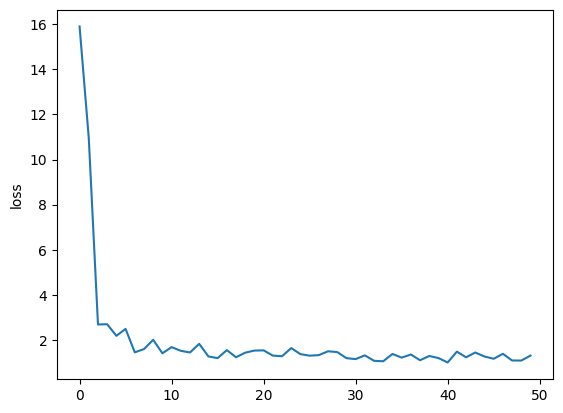

In [55]:
plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

In [110]:
# %load_ext tensorboard
%reload_ext tensorboard

In [111]:
# %tensorboard --logdir=$LOG_DIR

In [112]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir gs://rec-bandits-v2-hybrid-vertex-bucket/05a-onlinev1-rec-bandits-v2/run-20240207-153934/logs (started 1 day, 22:33:58 ago; pid 709913)


### evaluate post-training

In [58]:
# ====================================================
# Evaluate the agent's policy once after training
# ====================================================
print(f"evaluating trained Agent...")

post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)
start_time = time.time()

val_loss, preds, tr_rewards = eval_perarm._run_bandit_eval(
    policy = post_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM,
    vocab_dict = VOCAB_DICT,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"post-train val_loss     : {val_loss}")
print(f"post-train eval runtime : {runtime_mins}")

evaluating trained Agent...
post-train val_loss     : 1.3562124967575073
post-train eval runtime : 0


# (2) Serving Trained Policy v1

* Can't load with `tf.saved_model.load(SAVE_POLICY_DIR)`

In [62]:
SAVE_POLICY_DIR

'tmp_dir_v1/policy/policy_0'

In [66]:
saved_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    SAVE_POLICY_DIR, load_specs_from_pbtxt=True
)

saved_policy

### Generate predictions (actions)

In [68]:
INFER_SIZE = 1
dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

SKIP_NUM = 10

for x in eval_ds.skip(SKIP_NUM).take(INFER_SIZE):
    # get feature tensors
    
    global_feat_infer = embs._get_global_context_features(x)
    arm_feat_infer = embs._get_per_arm_features(x)
    
    # rewards = _get_rewards(x)
    rewards = reward_factory._get_rewards(x)
    
    # reshape arm features
    arm_feat_infer = tf.reshape(arm_feat_infer, [HPARAMS['eval_batch_size'], PER_ARM_DIM]) # perarm_dim
    concat_arm = tf.concat([arm_feat_infer, dummy_arm], axis=0)
    
    # flatten global
    flat_global_infer = tf.reshape(global_feat_infer, [GLOBAL_DIM])
    feature = {'global': flat_global_infer, 'per_arm': concat_arm}
    
    # get actual reward
    actual_reward = rewards.numpy()[0]
    
    # build trajectory step
    trajectory_step = train_utils._get_eval_step(feature, actual_reward)
    
    prediction = saved_policy.action(trajectory_step)

In [69]:
prediction

PolicyStep(action=array(0, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.4420016, 3.2875795], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=array([1], dtype=int32), chosen_arm_features=array([ 0.01512526,  0.01463176,  0.04306493,  0.02634757,  0.02050364,
       -0.02691734, -0.04732387, -0.01014247,  0.00909616, -0.02351855,
        0.03621415, -0.03008725,  0.01309245, -0.01096519,  0.00378894,
       -0.02403705,  0.02907662,  0.01840464, -0.0266034 , -0.00288539,
        0.0293371 ,  0.02887173, -0.02802934,  0.02223355, -0.00519679,
       -0.04653555,  0.01358154,  0.01241325, -0.02529163,  0.03460256,
        0.02198031, -0.00950336,  0.0447169 , -0.04901514, -0.03849282,
       -0.01054412, -0.0187006 ,  0.03128841,  0.01501706,  0.01084423,
        0.01198772, -0.03545277, -0.0271072 , -0.04548055, -0.0316849 ,
        0.

# (3) Online learning

> Here we'll simulate all the actions that need to happen on an online endpoint

For "online learning" to take place, the agent's policy needs to be updated, where "updated" is conceptually similar to retraining a traditional supervised learning model (with latest training examples) and deploying the newly trained model
* the bandit agent's policy is updated (i.e., learns) when it receives (e.g., `agent.train(...)`) a trajectory that includes the prediction/action AND the delayed feedback
* once `agent.train(...)` takes place, the policy is updated (e.g., weights)

### Load agent checkpoint

In [97]:
deployed_step_metric = tf_metrics.EnvironmentSteps()
deployed_metrics = [
    # tf_metrics.NumberOfEpisodes(),
    # tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]

pprint(f"deployed_metrics: {deployed_metrics}")

('deployed_metrics: [<tf_agents.metrics.tf_metrics.AverageReturnMetric object '
 'at 0x7f5779324e80>]')


In [98]:
deployed_agent = agent_factory.PerArmAgentFactory._get_agent(
    agent_type = AGENT_TYPE,
    network_type = NETWORK_TYPE,
    time_step_spec = time_step_spec,
    action_spec = action_spec,
    observation_spec=observation_spec,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    # train_step_counter = global_step,
    output_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
    # summarize_grads_and_vars = True,
    debug_summaries = True
)
      
deployed_agent.initialize()
print(f'agent: {deployed_agent.name}')

agent: NeuralEpsGreedyAgent


In [101]:
global_step

MirroredVariable:{
  0: <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=150>
}

In [99]:
CHKPOINT_DIR

'tmp_dir_v1/checkpoint'

In [100]:
deployed_agent.train_step_counter

MirroredVariable:{
  0: <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=150>
}

In [76]:
deployed_checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHKPOINT_DIR, 
    agent=deployed_agent, 
    metrics=deployed_metrics, 
    step_metric=deployed_step_metric
)

In [78]:
# confirm train step counter
deployed_agent.train_step_counter

MirroredVariable:{
  0: <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=50>
}

#### eval deployed agent

> validate metrics on eval set reflect trained policy

In [79]:
# ====================================================
# Evaluate the agent's policy once before training
# ====================================================
deployed_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(deployed_agent.policy, use_tf_function=True)

print(f"evaluating pre-trained Agent...")
start_time = time.time()

pre_val_loss, pre_preds, pre_tr_rewards = eval_perarm._run_bandit_eval(
    policy = deployed_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM,
    vocab_dict = VOCAB_DICT,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"pre-train val_loss     : {pre_val_loss}")
print(f"pre-train eval runtime : {runtime_mins}")

evaluating pre-trained Agent...
pre-train val_loss     : 1.3393412828445435
pre-train eval runtime : 0


#### Train loop on endpoint

In [80]:
NUM_TRAIN_STEPS = 100

In [81]:
list_o_loss = []

# ====================================================
# train loop
# ====================================================
print(f"starting train loop...")
start_time = time.time()

# for i in tqdm(range(NUM_TRAIN_STEPS)):
for i in range(NUM_TRAIN_STEPS):

    with train_summary_writer.as_default():

        data = next(train_ds_iterator)
        trajectories = _trajectory_fn(data)

        # All tensors in experience must be shaped [batch, time, ...] 
        step = deployed_agent.train_step_counter.numpy()
        loss = deployed_agent.train(experience=trajectories)
        list_o_loss.append(loss.loss.numpy())

        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=deployed_metrics
        )

        # print step loss
        if step % LOG_INTERVAL == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )

        # if i > 0 and i % CHKPT_INTERVAL == 0:
            # saver.save(os.path.join(CHKPOINT_DIR, 'policy_%d' % step_metric.result()))
            # deployed_checkpoint_manager.save(global_step)
            # print(f"saved policy to: {CHKPOINT_DIR}")

runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

starting train loop...
step = 50: train loss = 1.2000000476837158
step = 60: train loss = 1.4600000381469727
step = 70: train loss = 1.409999966621399
step = 80: train loss = 1.4199999570846558
step = 90: train loss = 1.1799999475479126
step = 100: train loss = 1.649999976158142
step = 110: train loss = 1.3200000524520874
step = 120: train loss = 1.1200000047683716
step = 130: train loss = 0.9100000262260437
step = 140: train loss = 1.0800000429153442
train runtime_mins: 1


In [82]:
!ls $CHKPOINT_DIR

checkpoint  ckpt-50.data-00000-of-00001  ckpt-50.index


In [83]:
deployed_checkpoint_manager.save(global_step)

'tmp_dir_v1/checkpoint/ckpt-150'

In [84]:
!ls $CHKPOINT_DIR

checkpoint		      ckpt-150.index		   ckpt-50.index
ckpt-150.data-00000-of-00001  ckpt-50.data-00000-of-00001


### save newly trained policy

In [89]:
# deployed_step_metric.result()
deployed_agent.train_step_counter.value().numpy()

150

In [90]:
NEW_SAVE_POLICY_DIR = os.path.join(POLICY_DIR, 'policy_%d' % deployed_agent.train_step_counter.value().numpy())
NEW_SAVE_POLICY_DIR

'tmp_dir_v1/policy/policy_150'

In [91]:
# saver.save(POLICY_DIR)
saver.save(NEW_SAVE_POLICY_DIR)
print(f"saved trained policy to: {NEW_SAVE_POLICY_DIR}")

saved trained policy to: tmp_dir_v1/policy/policy_150


### Create zip file and upload zip file

> export / import checkpointer and policy directories such that you can continue training at a later point and deploy the model without having to train again

In [ ]:
# def create_zip_file(dirname, base_filename):
#     return shutil.make_archive(base_filename, 'zip', dirname)

# def upload_and_unzip_file_to(dirname):
#     if files is None:
#         return
#     uploaded = files.upload()
#     for fn in uploaded.keys():
#         print(
#             'User uploaded file "{name}" with length {length} bytes'.format(
#                 name=fn, length=len(uploaded[fn])
#             )
#         )
#         shutil.rmtree(dirname)
#         zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
#         zip_files.extractall(dirname)
#         zip_files.close()

In [ ]:
# checkpoint_zip_filename = create_zip_file(CHKPOINT_DIR, os.path.join(tempdir, 'exported_cp'))
# checkpoint_zip_filename

In [ ]:
# # download zip file
# if files is not None:
#     files.download(checkpoint_zip_filename)

In [ ]:
# upload_and_unzip_file_to(CHKPOINT_DIR)
# checkpoint_manager.initialize_or_restore()
# global_step = tf.compat.v1.train.get_global_step()
# print(f"global_step : {global_step}")

# (4) Serving Trained Policy v2

In [92]:
NEW_SAVE_POLICY_DIR

'tmp_dir_v1/policy/policy_150'

In [93]:
saved_policy_v2 = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    NEW_SAVE_POLICY_DIR, load_specs_from_pbtxt=True
)

saved_policy_v2

In [94]:
INFER_SIZE = 1
dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

SKIP_NUM = 10

for x in eval_ds.skip(SKIP_NUM).take(INFER_SIZE):
    # get feature tensors
    
    global_feat_infer = embs._get_global_context_features(x)
    arm_feat_infer = embs._get_per_arm_features(x)
    
    # rewards = _get_rewards(x)
    rewards = reward_factory._get_rewards(x)
    
    # reshape arm features
    arm_feat_infer = tf.reshape(arm_feat_infer, [HPARAMS['eval_batch_size'], PER_ARM_DIM]) # perarm_dim
    concat_arm = tf.concat([arm_feat_infer, dummy_arm], axis=0)
    
    # flatten global
    flat_global_infer = tf.reshape(global_feat_infer, [GLOBAL_DIM])
    feature = {'global': flat_global_infer, 'per_arm': concat_arm}
    
    # get actual reward
    actual_reward = rewards.numpy()[0]
    
    # build trajectory step
    trajectory_step = train_utils._get_eval_step(feature, actual_reward)
    
    prediction = saved_policy_v2.action(trajectory_step)

In [95]:
prediction

PolicyStep(action=array(0, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.4420016, 3.2875795], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=array([1], dtype=int32), chosen_arm_features=array([ 0.01512526,  0.01463176,  0.04306493,  0.02634757,  0.02050364,
       -0.02691734, -0.04732387, -0.01014247,  0.00909616, -0.02351855,
        0.03621415, -0.03008725,  0.01309245, -0.01096519,  0.00378894,
       -0.02403705,  0.02907662,  0.01840464, -0.0266034 , -0.00288539,
        0.0293371 ,  0.02887173, -0.02802934,  0.02223355, -0.00519679,
       -0.04653555,  0.01358154,  0.01241325, -0.02529163,  0.03460256,
        0.02198031, -0.00950336,  0.0447169 , -0.04901514, -0.03849282,
       -0.01054412, -0.0187006 ,  0.03128841,  0.01501706,  0.01084423,
        0.01198772, -0.03545277, -0.0271072 , -0.04548055, -0.0316849 ,
        0.

In [96]:
processed_pred_dict = {
    "bandit_policy_type" : int(prediction.info.bandit_policy_type[0]),
    "chosen_arm_features" : prediction.info.chosen_arm_features.tolist(),
    "predicted_rewards_mean" : prediction.info.predicted_rewards_mean.tolist(),
    "action" : int(prediction.action.tolist()),
}

processed_pred_dict

{'bandit_policy_type': 1,
 'chosen_arm_features': [0.01512526348233223,
  0.014631759375333786,
  0.04306492581963539,
  0.026347566395998,
  0.02050364390015602,
  -0.026917338371276855,
  -0.04732387140393257,
  -0.01014246791601181,
  0.009096156805753708,
  -0.023518551141023636,
  0.03621414676308632,
  -0.030087245628237724,
  0.013092447072267532,
  -0.010965190827846527,
  0.003788936883211136,
  -0.02403705194592476,
  0.029076624661684036,
  0.018404636532068253,
  -0.026603400707244873,
  -0.0028853900730609894,
  0.029337096959352493,
  0.028871726244688034,
  -0.028029335662722588,
  0.022233549505472183,
  -0.005196787416934967,
  -0.04653555154800415,
  0.013581540435552597,
  0.012413252145051956,
  -0.02529163472354412,
  0.03460255637764931,
  0.02198031172156334,
  -0.009503364562988281,
  0.04471689835190773,
  -0.049015142023563385,
  -0.03849282115697861,
  -0.010544121265411377,
  -0.018700599670410156,
  0.03128841146826744,
  0.015017058700323105,
  0.010844230

**Finished**